In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# Function to generate feature plots with KDE
def generate_feature_plots(num_features, X_class_0, X_class_1):
    rows = 2
    cols = 3
    fig, axes = plt.subplots(figsize=(15, 10), nrows=rows, ncols=cols)

    color0 = 'blue'
    color1 = 'red'

    for r, row in enumerate(axes):
        for c, axScatter in enumerate(row):
            feature_idx = r * cols + c  # Determine feature index

            # Extract the selected feature
            feature_class_0 = X_class_0[:, feature_idx]
            feature_class_1 = X_class_1[:, feature_idx]
            x_class_0 = np.arange(len(X_class_0[:, feature_idx]))
            x_class_1 = np.arange(len(X_class_1[:, feature_idx]))

            # Scatter plot with customized styling
            axScatter.scatter(x_class_0, feature_class_0, color=color0, alpha=0.6, s=50, edgecolors='black', label="Class 0")
            axScatter.scatter(x_class_1, feature_class_1, color=color1, alpha=0.6, s=50, edgecolors='black', label="Class 1")

            axScatter.set_aspect('auto')
            axScatter.set_title(f"Feature {feature_idx + 1}", fontsize=14)
            axScatter.ticklabel_format(style='sci', scilimits=(0,4))
            axScatter.legend(fontsize=15)

            # Create new axes on the right for histograms
            divider = make_axes_locatable(axScatter)
            axHisty = divider.append_axes("right", 1, pad=0.1, sharey=axScatter)

            # Make the y-axis label of the histogram invisible
            axHisty.yaxis.set_tick_params(labelleft=False)

            # Set histogram bins
            num_bins = 30

            # Plot the histograms with a smooth edge
            axHisty.hist(feature_class_0, bins=num_bins, orientation='horizontal', color=color0, edgecolor='grey', linewidth=1.5, alpha=0.4)
            axHisty.hist(feature_class_1, bins=num_bins, orientation='horizontal', color=color1, edgecolor='grey', linewidth=1.5, alpha=0.4)

    # Adjust the layout to avoid overlap
    plt.tight_layout()
    plt.show()

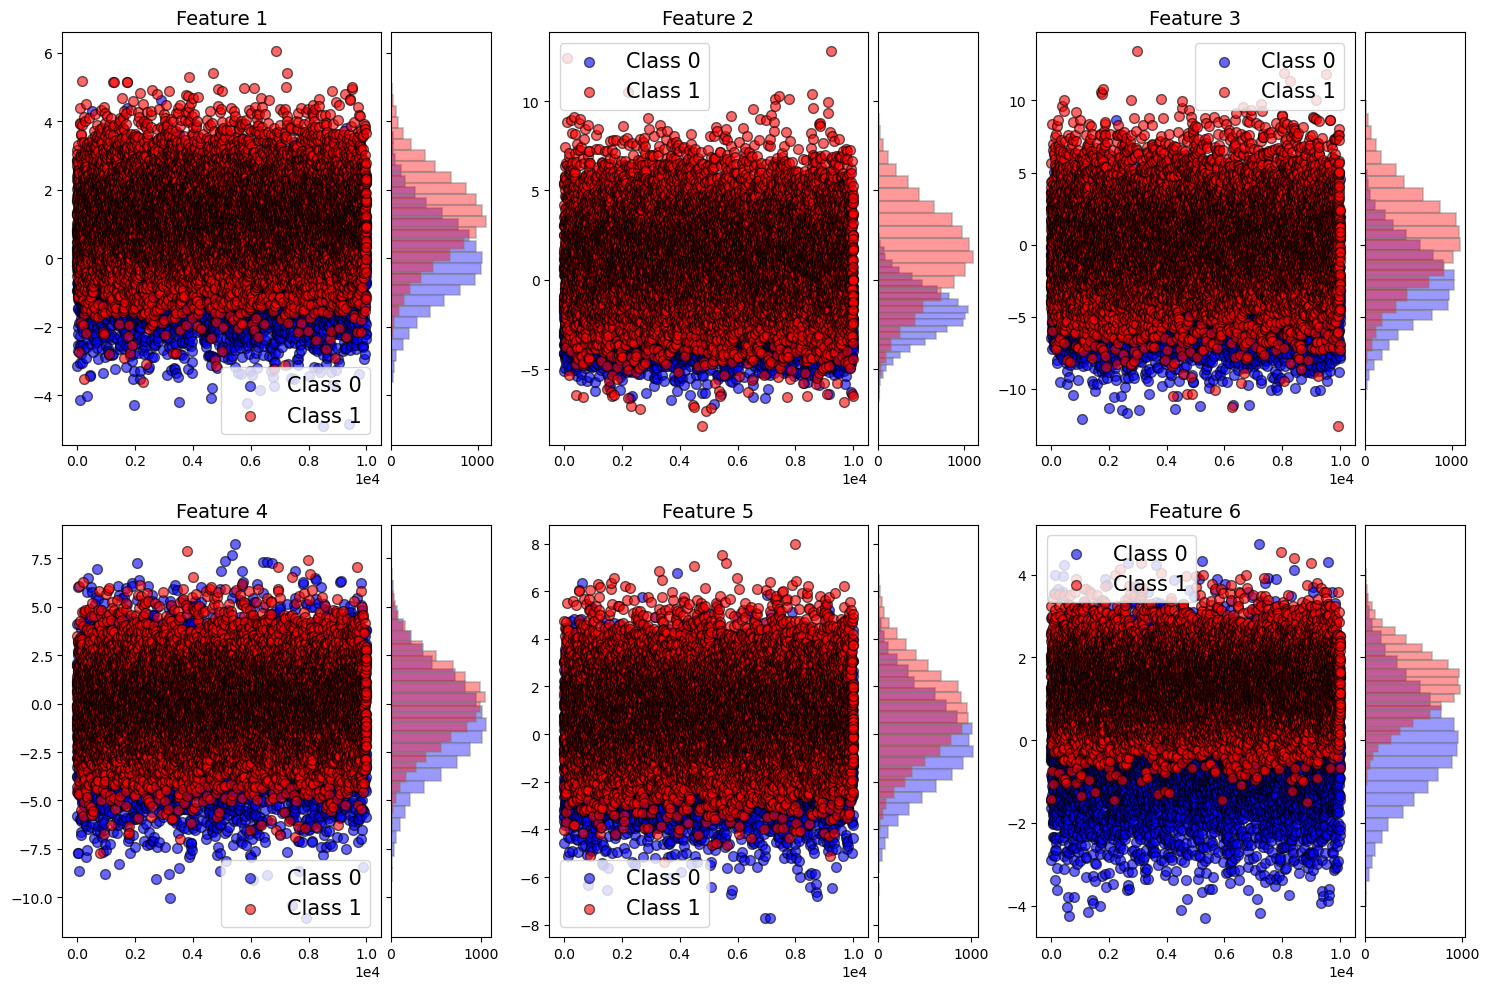

In [7]:
num_samples = 10000
# Run optimization and plot KDE
num_features = 6
means_class_0 = np.random.uniform(-3, 0, size=num_features)
covs_class_0 = np.diag(np.random.uniform(0.5, 10, size=num_features))
means_class_1 = np.random.uniform(0, 3, size=num_features)
covs_class_1 = np.diag(np.random.uniform(0.5, 10, size=num_features))

X_class_0 = np.random.multivariate_normal(means_class_0, covs_class_0, size=num_samples)
X_class_1 = np.random.multivariate_normal(means_class_1, covs_class_1, size=num_samples)

moments_1 = (means_class_0, means_class_1)
moments_2 = (covs_class_0, covs_class_1)

# Plot KDE for features
generate_feature_plots(num_features, X_class_0, X_class_1)


In [8]:
# Gradient calculation for binary cross-entropy loss
def gradient_function(A, x, b):
    """Computes the gradient of binary cross-entropy loss."""
    probabilities = 1 / (1 + np.exp(-A @ x))
    return (1 / len(b)) * A.T @ (probabilities - b)


In [9]:
# Custom optimization function
def optimize(moments_1, moments_2, wt_init, num_iterations, alpha, s0, beta, batch_size_init):
    # Initialize parameters for Gaussian distributions
    (means_class_0, means_class_1) = moments_1
    (covs_class_0, covs_class_1) = moments_2

    def sample_data(batch_size):
        # Sample points from both classes
        X_class_0 = np.random.multivariate_normal(means_class_0, covs_class_0, size=batch_size // 2)
        X_class_1 = np.random.multivariate_normal(means_class_1, covs_class_1, size=batch_size // 2)
        y_class_0 = np.zeros((batch_size // 2, 1))
        y_class_1 = np.ones((batch_size // 2, 1))
        
        X = np.vstack((X_class_0, X_class_1))
        y = np.vstack((y_class_0, y_class_1))

        # Shuffle data
        indices = np.arange(batch_size)
        np.random.shuffle(indices)
        return X[indices], y[indices]

    # Initialize optimization variables
    xk = wt_init
    xk_minus_1 = xk - np.random.uniform(0, 1, size=xk.shape)
    s_k = s0
    s_k_minus_1 = s0
    beta_k = beta
    beta_k_minus_1 = beta
    batch_size = batch_size_init
    X_batch_init, y_batch_init = sample_data(batch_size)
    X_batch_true_init, y_batch_true_init = sample_data(10000)
    grad_list = [gradient_function(X_batch_init, xk, y_batch_init)]
    loss_list = [np.mean(-y_batch_init * np.log(1 / (1 + np.exp(-X_batch_init @ xk))) - (1 - y_batch_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_init @ xk))))]
    vel_norms_list = [np.linalg.norm(xk)]
    true_grad_list = [gradient_function(X_batch_true_init, xk, y_batch_true_init)]
    pop_loss_list = [np.mean(-y_batch_true_init * np.log(1 / (1 + np.exp(-X_batch_true_init @ xk))) - (1 - y_batch_true_init) * np.log(1 - 1 / (1 + np.exp(-X_batch_true_init @ xk))))]

    for k in range(2, num_iterations + 1):
        # Sample data dynamically
        X_batch, y_batch = sample_data(batch_size)
        
        # Calculate t_k and other parameters
        t_k = (k - 1) / (alpha - 1)
        s_k = s0 / np.sqrt(k)
        beta_k = np.sqrt(s_k) / 4

        # Compute gradients
        grad_xk = gradient_function(X_batch, xk, y_batch)
        grad_xk_minus_1 = gradient_function(X_batch, xk_minus_1, y_batch)

        X_batch_true, y_batch_true = sample_data(10000)

        grad_true_xk = gradient_function(X_batch_true, xk, y_batch_true)

        alpha_k = 1 - (alpha / k)

        # Calculate yk
        yk = (
            xk
            + alpha_k * (xk - xk_minus_1)
            -  (beta_k*np.sqrt(s_k) * grad_xk - beta_k_minus_1 * np.sqrt(s_k_minus_1)*grad_xk_minus_1)
            - (beta_k_minus_1 * np.sqrt(s_k_minus_1) / k) * grad_xk_minus_1
        )

        # Update xk+1
        grad_yk = gradient_function(X_batch, yk, y_batch)
        xk_plus_1 = yk - s_k * grad_yk

        # Record velocity norms and loss
        vel_norms_list.append(np.linalg.norm(xk - xk_minus_1)) 
        loss_list.append(np.mean(-y_batch * np.log(1 / (1 + np.exp(-X_batch @ xk))) - (1 - y_batch) * np.log(1 - 1 / (1 + np.exp(-X_batch @ xk)))))

        pop_loss_list.append(np.mean(-y_batch_true * np.log(1 / (1 + np.exp(-X_batch_true @ xk))) - (1 - y_batch_true) * np.log(1 - 1 / (1 + np.exp(-X_batch_true @ xk)))))
        
        grad_list.append(grad_xk)
        true_grad_list.append(grad_true_xk)
        # Update variables for next iteration
        xk_minus_1 = xk
        xk = xk_plus_1
        s_k_minus_1 = s_k
        beta_k_minus_1 = beta_k

        batch_size += 8

        
        print(f"Iteration {k}: Loss = {loss_list[-1]:.4f}, Step Size s_k = {s_k:.6f}")

    return vel_norms_list, loss_list, pop_loss_list, grad_list, true_grad_list


In [20]:
# Optimize
initial_weights_list = [np.random.uniform(-1, 1, (num_features, 1)) for _ in range(25)]

# Run optimization for all initial weights
all_vels = []
all_losses = []
all_pop_losses = []
all_grads = []

for i, initial_weight in enumerate(initial_weights_list):
    
    print(f"Strating for weight set {i}")
    vel_norms, losses, pop_losses, grads, true_grads = optimize(moments_1, moments_2, initial_weight, num_iterations=80, alpha=3.1, s0=0.1, beta=0.079, batch_size_init=8)
    all_vels.append(vel_norms[2:])
    all_losses.append(losses[2:])
    all_grads.append(true_grads[2:])
    all_pop_losses.append(pop_losses[2:])

Strating for weight set 0
Iteration 2: Loss = 1.9225, Step Size s_k = 0.070711
Iteration 3: Loss = 2.8723, Step Size s_k = 0.057735
Iteration 4: Loss = 1.9637, Step Size s_k = 0.050000
Iteration 5: Loss = 2.0997, Step Size s_k = 0.044721
Iteration 6: Loss = 2.3110, Step Size s_k = 0.040825
Iteration 7: Loss = 1.6393, Step Size s_k = 0.037796
Iteration 8: Loss = 1.3113, Step Size s_k = 0.035355
Iteration 9: Loss = 1.6294, Step Size s_k = 0.033333
Iteration 10: Loss = 1.2580, Step Size s_k = 0.031623
Iteration 11: Loss = 0.9568, Step Size s_k = 0.030151
Iteration 12: Loss = 0.7959, Step Size s_k = 0.028868
Iteration 13: Loss = 0.7543, Step Size s_k = 0.027735
Iteration 14: Loss = 0.6012, Step Size s_k = 0.026726
Iteration 15: Loss = 0.5337, Step Size s_k = 0.025820
Iteration 16: Loss = 0.4341, Step Size s_k = 0.025000
Iteration 17: Loss = 0.4469, Step Size s_k = 0.024254
Iteration 18: Loss = 0.4090, Step Size s_k = 0.023570
Iteration 19: Loss = 0.4471, Step Size s_k = 0.022942
Iteration 

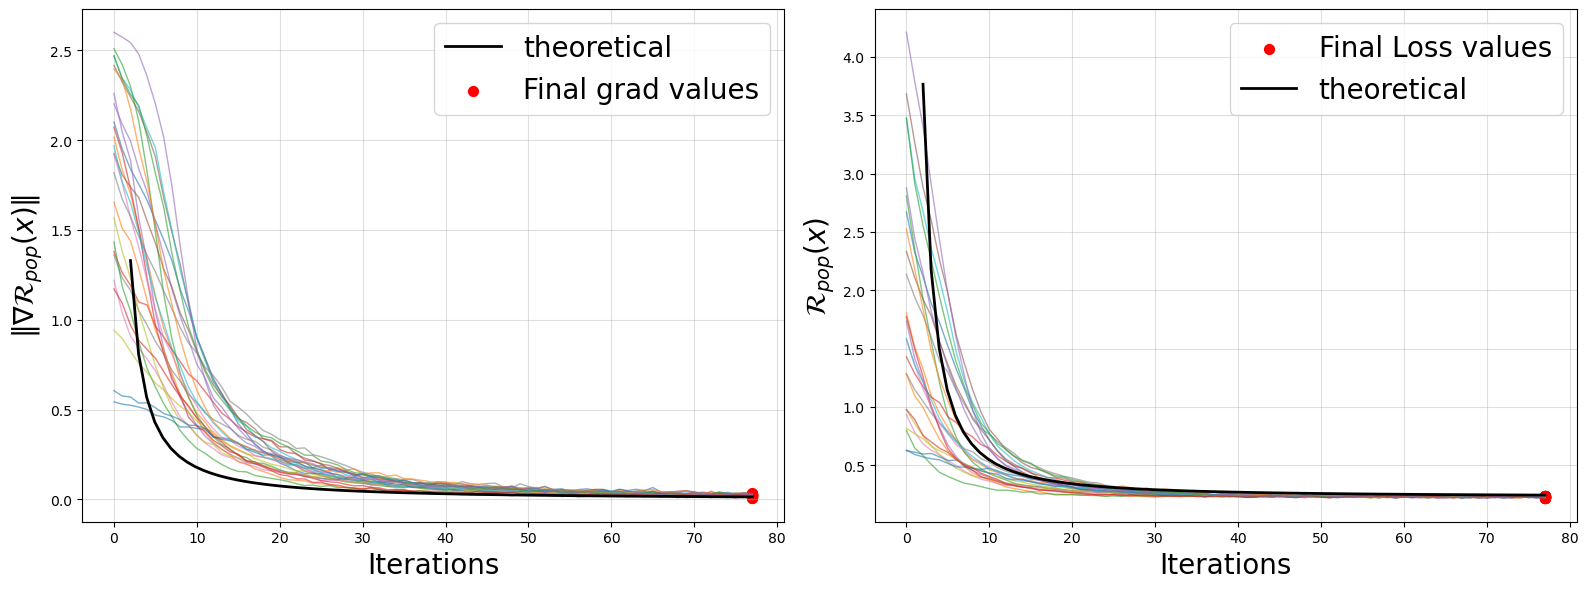

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assume all_trajectories and all_losses are generated
# Each trajectory/loss is a list of arrays

# Plotting results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
x = np.linspace(2, 77, 78)
y = 10/x**(1.5) + 0.23
dy = ((10)**0.5 )/x**(1.25) + 0.2
# 1. Plot trajectories of x_k
#axes[0].set_title(r"Trajectories of Iterates $(\(x_k\))$")
for trajectory in all_grads:
    trajectory = np.array(trajectory)
    # Plot trajectory norm ||x_k|| over iterations
    norm_trajectory = np.linalg.norm(trajectory, axis=1)
    axes[0].plot(np.arange(len(norm_trajectory)), norm_trajectory, alpha=0.6, linewidth=1)

axes[0].plot(x, dy, label="theoretical", color="black", linewidth=2)
# Final points in trajectories
final_norms = [np.linalg.norm(trajectory[-1]) for trajectory in all_grads]
axes[0].scatter([len(trajectory) - 1] * len(final_norms), final_norms, color='red', s=50, label='Final grad values')

axes[0].set_xlabel("Iterations", fontsize=20)
axes[0].set_ylabel(r"$\|\nabla \mathcal{R}_{pop}(x)\|$", fontsize=20)
axes[0].legend(fontsize=20)
axes[0].grid(alpha=0.4)


# 2. Plot function values f(x_k)
#axes[1].set_title(r"Function Values $(\(f(x_k)\))$")
for loss in all_pop_losses:
    axes[1].plot(np.arange(len(loss)), loss, alpha=0.6, linewidth=1)

# Final losses
final_losses = [loss[-1] for loss in all_pop_losses]
axes[1].scatter([len(loss) - 1] * len(final_losses), final_losses, color='red', s=50, label='Final Loss values')

axes[1].set_xlabel("Iterations", fontsize=20)
axes[1].set_ylabel(r"$\mathcal{R}_{pop}(x)$", fontsize=20)
axes[1].legend(fontsize=20)
axes[1].grid(alpha=0.4)
axes[1].plot(x, y, label='theoretical', color='black', linewidth=2)
axes[1].legend(fontsize=20)

plt.plot()
plt.tight_layout()
plt.show()
plt.savefig('grad_flow.png')
